# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
keras = tf.keras

***
# Data preparation

## Loading the data

In [50]:
df = pd.read_csv(
    '../data/PowerConsumption_DE.csv',
    parse_dates=['start', 'end'],
)
df = df.set_index('start')

## Turn dates into datetimes

## Turn hourly data into daily sums
Google is your best friend if you do not know how to do this ;)

In [51]:
df_agg = df.resample(rule='1D').sum()
df_agg.head()

,load
start,
2015-01-01 00:00:00+00:00,4354040.0
2015-01-02 00:00:00+00:00,4986348.0
2015-01-03 00:00:00+00:00,4470214.0
2015-01-04 00:00:00+00:00,4327920.0
2015-01-05 00:00:00+00:00,5303683.0


## Scale the data

In [52]:
scaler = StandardScaler()
scaler = scaler.fit(df_agg)
scaled_train_df = scaler.transform(df_agg)
pd.DataFrame(scaled_train_df).describe()

,0
count,2.070000e+03
mean,-4.466636e-16
std,1.000242e+00
min,-2.501709e+00
25%,-7.686930e-01
50%,2.024746e-01
75%,7.550961e-01
max,1.913088e+00


## Create X and Y data

In [31]:
train_x_list = []
train_y_list = []

N_FUTURE = 1
N_PAST = 15

# we can only start at 15 so we have a full window, the last one must be 1
# window before the end
for i in range(N_PAST, len(scaled_train_df) - N_FUTURE + 1):
    # slice and append a moving window of 15
    train_x_list.append(scaled_train_df[i - N_PAST:i])
    # slice to next day (result we want to predict)
    train_y_list.append(scaled_train_df[i + N_FUTURE - 1:i + N_FUTURE, 0])

In [34]:
train_x = np.array(train_x_list)
train_y = np.array(train_y_list)
print(train_x.shape)
print(train_y.shape)

(2055, 15, 1)
(2055, 1)


***
# Built and train the model

In [35]:
model = keras.models.Sequential()
model.add(
    keras.layers.LSTM(
        64,
        input_shape=(train_x.shape[1], train_x.shape[2]),
        return_sequences=True,
    ),
)
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(train_y.shape[1]))


opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mse')
model.summary()

history = model.fit(
    train_x, train_y, epochs=20,
    batch_size=16, validation_split=0.1,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
116/116 [==============================] - 5s 15ms/step - loss: 0.7834 - val_loss: 0.7149
Epoch 2/20
116/116 [==============================] - 1s 9ms/step - loss: 0.7215 - 

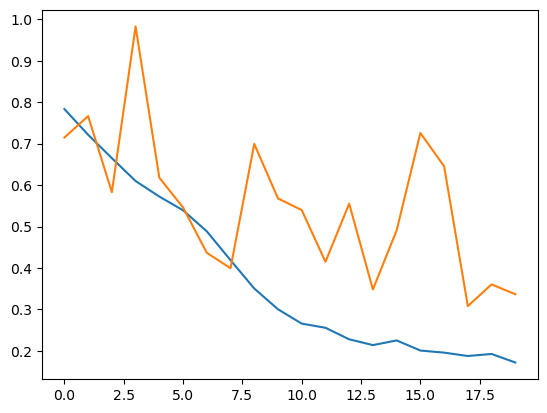

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

***
# Deploy the model

## Predict the whole training data

In [38]:
forecast = model.predict(train_x)
forecast

65/65 [==============================] - 1s 4ms/step


array([[ 0.8863565 ],
       [-0.09765175],
       [-1.2372869 ],
       ...,
       [-0.9704183 ],
       [-2.0852373 ],
       [-0.7337827 ]], dtype=float32)

## Undo the scaling 

In [53]:
forecast_copy = np.repeat(forecast, scaled_train_df.shape[1], axis=-1)
print(forecast_copy.shape)
y_pred = scaler.inverse_transform(forecast_copy)[:, :1]
y_pred

(2055, 1)


array([[5893003. ],
       [5267540.5],
       [4543157. ],
       ...,
       [4712786. ],
       [4004176. ],
       [4863198. ]], dtype=float32)

## Create a dataframe that can store the real and predicted values

### Make a copy of the real Dataframe

In [56]:
real = df_agg[N_PAST:].copy().reset_index()
real

,start,load
0,2015-01-16 00:00:00+00:00,5725653.0
1,2015-01-17 00:00:00+00:00,4908832.0
2,2015-01-18 00:00:00+00:00,4558769.0
3,2015-01-19 00:00:00+00:00,5829195.0
4,2015-01-20 00:00:00+00:00,5957013.0
...,...,...
2050,2020-08-27 00:00:00+00:00,5309500.0
2051,2020-08-28 00:00:00+00:00,5111869.0
2052,2020-08-29 00:00:00+00:00,4313439.0
2053,2020-08-30 00:00:00+00:00,4023384.0


### Turn the predicted data into a dataframe

In [57]:
pred = pd.DataFrame(y_pred, columns=['predicted']).reset_index(drop=True)
pred

,predicted
0,5893003.0
1,5267540.5
2,4543157.0
3,5400062.5
4,5777011.0
...,...
2050,5418382.0
2051,5300559.5
2052,4712786.0
2053,4004176.0


### Merge the dataframes

In [58]:
new_df = pd.concat([real, pred], axis=1)
new_df = new_df.set_index('start')
new_df

,load,predicted
start,,
2015-01-16 00:00:00+00:00,5725653.0,5893003.0
2015-01-17 00:00:00+00:00,4908832.0,5267540.5
2015-01-18 00:00:00+00:00,4558769.0,4543157.0
2015-01-19 00:00:00+00:00,5829195.0,5400062.5
2015-01-20 00:00:00+00:00,5957013.0,5777011.0
...,...,...
2020-08-27 00:00:00+00:00,5309500.0,5418382.0
2020-08-28 00:00:00+00:00,5111869.0,5300559.5
2020-08-29 00:00:00+00:00,4313439.0,4712786.0


## Plot the whole dataframe with predicted and real values

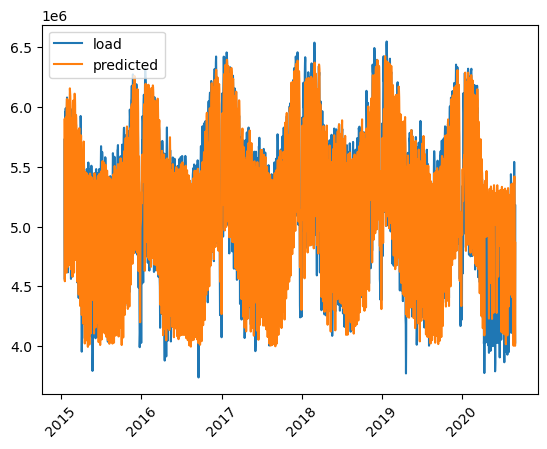

In [59]:
plt.xticks(rotation=45)
plt.plot(new_df)
plt.legend(new_df.columns)

## Take a closer look on the data which was saved for validation

### Truncate the validation data

In [60]:
validation_data = int(len(new_df) * 0.1)
val_data = new_df[-validation_data:]
val_data

,load,predicted
start,,
2020-02-09 00:00:00+00:00,4751691.0,4781250.0
2020-02-10 00:00:00+00:00,6028349.0,6015993.0
2020-02-11 00:00:00+00:00,6297658.0,6194087.5
2020-02-12 00:00:00+00:00,6308432.0,6264813.5
2020-02-13 00:00:00+00:00,6317693.0,6254052.5
...,...,...
2020-08-27 00:00:00+00:00,5309500.0,5418382.0
2020-08-28 00:00:00+00:00,5111869.0,5300559.5
2020-08-29 00:00:00+00:00,4313439.0,4712786.0


### Calculate the RMSE

In [63]:
rmse = np.sqrt(mean_squared_error(val_data['load'], val_data['predicted']))
print(f'RMSE: {rmse:.2f}')

RMSE: 369747.98


###  Plot the predicted and real validation data

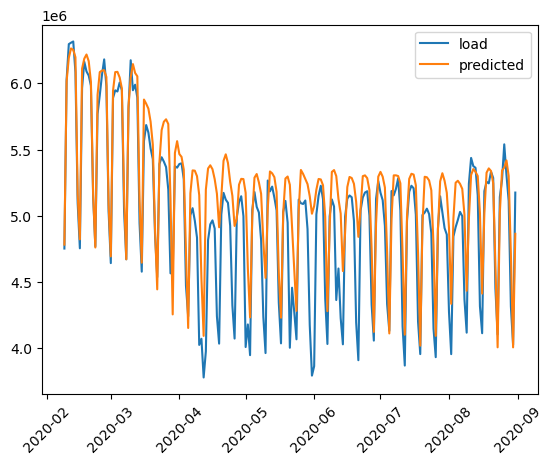

In [64]:
plt.xticks(rotation=45)
plt.plot(val_data)
plt.legend(val_data.columns)